In [73]:
import numpy as np
import matplotlib.pyplot as plt
import re
from utils import emotion_scores
import pickle

In [74]:
print(emotion_scores("I am happy"))

[{'label': 'sadness', 'score': 0.0005438440130092204}, {'label': 'joy', 'score': 0.998437225818634}, {'label': 'love', 'score': 0.0004561921814456582}, {'label': 'anger', 'score': 0.0002622490865178406}, {'label': 'fear', 'score': 0.00014311514678411186}, {'label': 'surprise', 'score': 0.00015750851889606565}]


In [39]:
# Implement the Bigram Language Model Class
class BigramLM:
    def __init__(self):
        self.bigram_freq = {}
        self.total_freq = {}
        self.vocab = set()
        self.vocab_size = 0
        self.corpus_size = 0
        self.corpus = [] 
        self.labels = []

    # Preprocess the text
    def preprocess_text(self, text):
        # Convert to lowercase
        text = text.lower()

        # Remove all non-alphanumeric characters
        text = re.sub(r'[^a-z0-9\s]', '', text)
        return text
    
    # Train the bigram language model
    def train_lm(self, corpus, labels):
        # Open the corpus and labels file and read it
        with open(corpus, 'r', encoding='utf-8') as corpus_file, open(labels, 'r', encoding='utf-8') as labels_file:
            for line in corpus_file:
                tokens = self.preprocess_text(line).split()
                self.corpus.append(tokens)

            for line in labels_file:
                self.labels.append(line.strip())
        
        # Get the vocabulary
        self.vocab = set([word for sentence in self.corpus for word in sentence])

        # Get the vocabulary size
        self.vocab_size = len(self.vocab)

        # Get the corpus size
        self.corpus_size = len(self.corpus)

        for sentence in self.corpus:
            for i in range(len(sentence) - 1):
                # Get the bigram frequencies
                bigram = (sentence[i], sentence[i + 1])
                self.bigram_freq[bigram] = self.bigram_freq.get(bigram, 0) + 1

                # Get the unigram frequencies
                unigram = sentence[i]
                self.total_freq[unigram] = self.total_freq.get(unigram, 0) + 1

                # Handling end of sentence
                if(i == len(sentence) - 2):
                    unigram = sentence[i + 1]
                    self.total_freq[unigram] = self.total_freq.get(unigram, 0) + 1

                    # end of sentence bigram
                    bigram = (sentence[i + 1], '<end>')
                    self.bigram_freq[bigram] = self.bigram_freq.get(bigram, 0) + 1

                # Handling start of sentence
                if(i == 0):
                    bigram = ('<start>', sentence[i])
                    self.bigram_freq[bigram] = self.bigram_freq.get(bigram, 0) + 1
                    unigram = '<start>'
                    self.total_freq[unigram] = self.total_freq.get(unigram, 0) + 1

    # Save the bigram language model to a pickle file
    def save_model(self, filename):
        with open(filename, 'wb') as file:
            pickle.dump(self, file)

    # Load the bigram language model from a pickle file
    def load_model(self, filename):
        with open(filename, 'rb') as file:
            model = pickle.load(file)
            return model

    # Get the probability of a bigram without smoothing
    def get_bigram_prob(self, previous_word, next_word):
        bigram = (previous_word, next_word)
        # If the bigram is not present in the corpus, return 0
        if bigram not in self.bigram_freq:
            return 0
        else:
            return self.bigram_freq[bigram] / self.total_freq[previous_word]
        
    # Q2 
    # Get the probability of a bigram with laplace smoothing
    def get_bigram_prob_laplace(self, previous_word, next_word):
        bigram = (previous_word, next_word)
        
        # Retrieve frequency of bigram and add 1
        bigram_freq_smoothed = self.bigram_freq.get(bigram, 0) + 1

        # Retrieve frequency of previous word and add the vocabulary size
        previous_word_freq_smoothed = self.total_freq.get(previous_word, 0) + self.vocab_size

        # Return the probability
        return bigram_freq_smoothed / previous_word_freq_smoothed
    
    # Get the probability of a bigram with kneser-ney smoothing
    

In [40]:
bigram_lm = BigramLM()

bigram_lm.train_lm('data/corpus.txt', 'data/labels.txt')

# Save the bigram language model to a pickle file
bigram_lm.save_model('bigram_lm.pkl')

In [41]:
# Load the bigram language model from a pickle file
bigram_lm2 = bigram_lm.load_model('bigram_lm.pkl')
# Print top 5 most probable bigrams without smoothing
print('Top 5 most probable bigrams without smoothing: ')
for bigram in sorted(bigram_lm2.bigram_freq, key=bigram_lm2.bigram_freq.get, reverse=True)[:5]:
    print(f"{bigram} :  {bigram_lm2.bigram_freq[bigram]}")

print("-------------------")
print()
# Print top 5 most probable bigrams with laplace smoothing
print('Top 5 most probable bigrams with laplace smoothing: ')

# First find the probability of each bigram with laplace smoothing
bigram_prob = {}
for bigram in bigram_lm2.bigram_freq:
    bigram_prob[bigram] = bigram_lm2.get_bigram_prob_laplace(bigram[0], bigram[1])
# Then sort the bigrams by probability and print the top 5
for bigram in sorted(bigram_prob, key=bigram_prob.get, reverse=True)[:5]:
    print(f"{bigram} :  {bigram_prob[bigram]}")
    

Top 5 most probable bigrams without smoothing: 
('<start>', 'i') :  2108
('i', 'feel') :  1017
('i', 'am') :  293
('feel', 'like') :  247
('<start>', 'im') :  212
-------------------

Top 5 most probable bigrams with laplace smoothing: 
('<start>', 'i') :  0.2693830629710052
('i', 'feel') :  0.11043610327619874
('feel', 'like') :  0.0350976507217662
('i', 'am') :  0.03189412019960946
('<start>', 'im') :  0.02720653978796781


In [42]:
print(len(bigram_lm2.bigram_freq))

25681


In [43]:
# Return emotion scores for each bigram
def get_emotion_score_bigram(bigram_lm):
    
    # Store the bigram probabilities without emotion scores
    bigram_prob_dict = {}
    bigram_frequencies = bigram_lm.bigram_freq
    for bigram in bigram_frequencies:
        bigram_prob_dict[bigram] = bigram_lm.get_bigram_prob(bigram[0], bigram[1])

    # Get the emotion scores for each bigram
    emotion_prob_dict = {}
    i = 0
    for bigram in bigram_frequencies:
        i += 1
        # convert bigram to a string
        if bigram[0] == '<start>':
            bigram_str = bigram[1]
        elif bigram[1] == '<end>':
            bigram_str = bigram[0]
        else:
            bigram_str = bigram[0] + ' ' + bigram[1]
        
        # Get the emotion score for the bigram
        emotion_prob_dict[bigram] = emotion_scores(bigram_str)
        print(i)

    return bigram_prob_dict, emotion_prob_dict



In [44]:
bigram_prob_dict, emotion_prob_dict = get_emotion_score_bigram(bigram_lm2)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [46]:
for x,y in emotion_prob_dict.items():
    print(x, y)

('i', 'stand') [{'label': 'sadness', 'score': 0.0328662283718586}, {'label': 'joy', 'score': 0.6205072999000549}, {'label': 'love', 'score': 0.00595947215333581}, {'label': 'anger', 'score': 0.3174065053462982}, {'label': 'fear', 'score': 0.020320601761341095}, {'label': 'surprise', 'score': 0.0029398745391517878}]
('<start>', 'i') [{'label': 'sadness', 'score': 0.04209383949637413}, {'label': 'joy', 'score': 0.06655298173427582}, {'label': 'love', 'score': 0.0036040579434484243}, {'label': 'anger', 'score': 0.817751944065094}, {'label': 'fear', 'score': 0.06688779592514038}, {'label': 'surprise', 'score': 0.0031094681471586227}]
('stand', 'here') [{'label': 'sadness', 'score': 0.01706145703792572}, {'label': 'joy', 'score': 0.0886385440826416}, {'label': 'love', 'score': 0.00471338490024209}, {'label': 'anger', 'score': 0.849322497844696}, {'label': 'fear', 'score': 0.0374404713511467}, {'label': 'surprise', 'score': 0.002823564223945141}]
('here', 'i') [{'label': 'sadness', 'score': 

In [49]:
# Combine the bigram probabilities and emotion scores
def combine_pt_and_emotion(bigram_lm, bigram_prob_dict, emotion_prob_dict):
    bigram_frequencies = bigram_lm.bigram_freq

    # Define a dictionary for each emotion
    combined_prob_dict = {"joy": {}, "love": {}, "sadness": {}, "surprise": {}, "fear": {}, "anger": {}}

    # Initialise the dictionary with unigrams and assign an empty dictionary to each unigram
    for word in bigram_lm.total_freq:
        for emotion in combined_prob_dict:
            combined_prob_dict[emotion][word] = {}

    # Combine the probabilities and emotion scores
    for bigram in bigram_frequencies:
        # Get the previous and next word of the bigram
        prev_word = bigram[0]
        next_word = bigram[1]

        # Get the probability of the bigram
        bigram_prob = bigram_prob_dict[bigram]

        # Get the emotion scores for the bigram
        emotion_scores = emotion_prob_dict[bigram]

        for emotion in emotion_scores:
            # Get the particular emotional score for the bigram  
            curr_emo = emotion['label']
            curr_emo_score = emotion['score']

            # Add the bigram probability and emotion score to the dictionary
            combined_prob_dict[curr_emo][prev_word][next_word] = (bigram_prob + curr_emo_score)

    return combined_prob_dict

In [50]:
# Combine the probabilities and emotion scores
combined_prob_dict = combine_pt_and_emotion(bigram_lm2, bigram_prob_dict, emotion_prob_dict)

In [52]:
# Normalise the combined probabilities
def normalise_combined_prob(combined_prob_dict):
    # Normalise the combined probabilities
    for emotion in combined_prob_dict:
        for prev_word in combined_prob_dict[emotion]:
            # Get the total probability for the previous word
            total_prob = sum(combined_prob_dict[emotion][prev_word].values())

            for next_word in combined_prob_dict[emotion][prev_word]:
                # Normalise the probability
                combined_prob_dict[emotion][prev_word][next_word] = combined_prob_dict[emotion][prev_word][next_word] / total_prob

    return combined_prob_dict

# Call the normalise_combined_prob function
normalised_combined_prob = normalise_combined_prob(combined_prob_dict)

In [65]:
# Generate a sentence of a max length of 11 or end of sentence for emotion given using the bigram model
def generate_sentence(emotion, max_length=15, k=6):
    # Get the combined probabilities for the given emotion
    combined_prob = normalised_combined_prob[emotion]

    # Initialise the sentence with the start token
    sentence = ['<start>']

    # Get the previous word
    prev_word = sentence[-1]

    # Generate the sentence by picking the next word by selecting randomly from the top k most probable words (or less if there are less than k words)
    for i in range(max_length):

        # If start token is the previous word, choose from entire probable next words
        if prev_word == '<start>':
            next_word = np.random.choice(list(combined_prob[prev_word].keys()), p=list(combined_prob[prev_word].values()))
        
        # Else, choose from top k probable next words
        else:  
            # Get the top k probable next words
            top_k_words = sorted(combined_prob[prev_word], key=combined_prob[prev_word].get, reverse=True)[:(min(k, len(combined_prob[prev_word])))]

            # Make a new list of probabilities for the top k words with the same order as the top k words and normalise the probabilities
            top_k_prob = [combined_prob[prev_word][word] for word in top_k_words]
            top_k_prob = [prob / sum(top_k_prob) for prob in top_k_prob]

            # Choose the next word
            next_word = np.random.choice(top_k_words, p=top_k_prob)
            
        # If the next word is the end token, break
        if next_word == '<end>':
            break
        # else, append the next word to the sentence
        sentence.append(next_word)

        # Update the previous word
        prev_word = next_word
    
    # Return the sentence
    return ' '.join(sentence[1:])

In [66]:
# Generate a sentence for each emotion
for emotion in normalised_combined_prob:

    # Generate a sentence for the emotion
    sentence = generate_sentence(emotion)

    # Print the sentence with the emotion score
    print(f"{emotion.capitalize()}: {sentence}")
    print(f"Emotion score: {emotion_scores(sentence)}")
    print()


Joy: i believe that graceful but thank god has chosen as happy
Emotion score: [{'label': 'sadness', 'score': 0.0003071966057177633}, {'label': 'joy', 'score': 0.9987701773643494}, {'label': 'love', 'score': 0.00031218843651004136}, {'label': 'anger', 'score': 0.00022305783932097256}, {'label': 'fear', 'score': 0.00019841633911710232}, {'label': 'surprise', 'score': 0.00018907722551375628}]

Love: i love you love him tightly and liked just admiring it comforted knowing my adoring
Emotion score: [{'label': 'sadness', 'score': 0.0007570033194497228}, {'label': 'joy', 'score': 0.0026483391411602497}, {'label': 'love', 'score': 0.9928076267242432}, {'label': 'anger', 'score': 0.0004592287295963615}, {'label': 'fear', 'score': 0.0004380255122669041}, {'label': 'surprise', 'score': 0.0028897514566779137}]

Sadness: on empty again after failing to suffer i hurt as ugly dried figs because after
Emotion score: [{'label': 'sadness', 'score': 0.9980888962745667}, {'label': 'joy', 'score': 0.000262

In [67]:
# Generate 50 sentences for each emotion and save them to a unique file called "gen_<emotion>.txt"
for emotion in normalised_combined_prob:
    with open(f'gen_{emotion}.txt', 'w', encoding='utf-8') as file:
        for i in range(50):
            # Generate a sentence for the emotion
            sentence = generate_sentence(emotion)

            # Write the sentence to the file
            file.write(sentence + '\n')

Emotion: joy
1
[0.9986180067062378, 0.9988143444061279, 0.9989621639251709, 0.9989935755729675, 0.9990410208702087, 0.998735249042511, 0.9989466071128845, 0.9989305138587952, 0.9986220598220825, 0.9989683628082275, 0.9987855553627014, 0.998474657535553, 0.99741131067276, 0.9990679621696472, 0.9989026784896851, 0.9991024732589722, 0.9986691474914551, 0.9987686276435852, 0.9985175728797913, 0.9991070628166199, 0.9989680051803589, 0.9988701939582825, 0.9981572031974792, 0.9989911913871765, 0.9990604519844055, 0.9984416365623474, 0.9988534450531006, 0.999004065990448, 0.9972932934761047, 0.9985350370407104, 0.998874843120575, 0.9989755153656006, 0.9989297986030579, 0.9989132881164551, 0.9990450739860535, 0.9981836676597595, 0.9982740879058838, 0.9990395903587341, 0.9337162971496582, 0.9980236291885376, 0.9981319308280945, 0.9989398121833801, 0.9990382194519043, 0.9959495067596436, 0.9989203214645386, 0.9987381100654602, 0.9987428784370422, 0.9990034699440002, 0.9990154504776001, 0.99906939

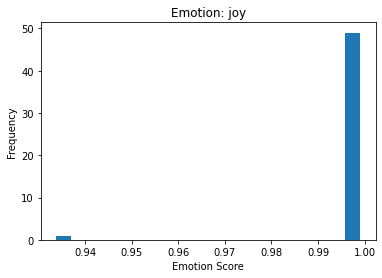

Emotion: love
2
[0.9959354400634766, 0.9839159846305847, 0.9952296018600464, 0.9948605895042419, 0.9953625202178955, 0.994754433631897, 0.9959169030189514, 0.9953325390815735, 0.9948107004165649, 0.9954441785812378, 0.995491087436676, 0.9943951368331909, 0.9938340187072754, 0.9954303503036499, 0.9954153299331665, 0.9955312609672546, 0.9948252439498901, 0.9953863024711609, 0.9479085803031921, 0.9938746094703674, 0.9954816102981567, 0.9930633902549744, 0.9949022531509399, 0.9956151247024536, 0.9948338270187378, 0.9940154552459717, 0.5064825415611267, 0.9941710829734802, 0.9839159846305847, 0.9954211115837097, 0.995227575302124, 0.995567262172699, 0.5064825415611267, 0.9957791566848755, 0.9958980679512024, 0.9954296350479126, 0.9839159846305847, 0.9952446818351746, 0.995564877986908, 0.9948796033859253, 0.9951426982879639, 0.9954385161399841, 0.9957606196403503, 0.9947746396064758, 0.9933956265449524, 0.995522141456604, 0.9956856966018677, 0.9954458475112915, 0.9949906468391418, 0.9952973

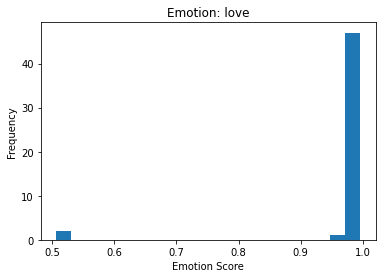

Emotion: sadness
0
[0.9986912608146667, 0.9986104965209961, 0.9988420605659485, 0.9983943104743958, 0.9987976551055908, 0.9924565553665161, 0.998975396156311, 0.9904595613479614, 0.9987548589706421, 0.9981902241706848, 0.9972568154335022, 0.9931378960609436, 0.9967283010482788, 0.9990037083625793, 0.9986060261726379, 0.998494029045105, 0.992229163646698, 0.9943549633026123, 0.9882595539093018, 0.9990184307098389, 0.9990569949150085, 0.9987118244171143, 0.9987383484840393, 0.9847431182861328, 0.9947882890701294, 0.9991099238395691, 0.9937769174575806, 0.045375097543001175, 0.997818112373352, 0.9989583492279053, 0.9946514964103699, 0.9990192651748657, 0.001369269099086523, 0.9983605742454529, 0.9972606897354126, 0.9979706406593323, 0.9990361928939819, 0.9990768432617188, 0.9909866452217102, 0.9972986578941345, 0.9972568154335022, 0.9909623265266418, 0.9985882639884949, 0.9981666803359985, 0.9983996748924255, 0.9986559152603149, 0.99810791015625, 0.9987474679946899, 0.9986279010772705, 0.

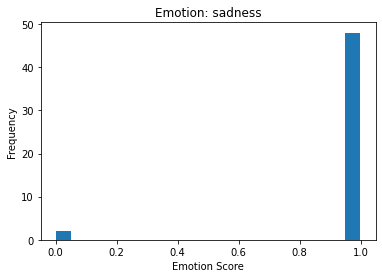

Emotion: surprise
5
[0.9915984869003296, 0.01807291805744171, 0.99146968126297, 0.9914006590843201, 0.10529221594333649, 0.9884244203567505, 0.9913568496704102, 0.9825113415718079, 0.985139787197113, 0.8800144195556641, 0.9913229942321777, 0.9809167981147766, 0.9918465614318848, 0.9917761087417603, 0.9911093711853027, 0.991754412651062, 0.9917014241218567, 0.9906784296035767, 0.9906596541404724, 0.9914634823799133, 0.9903910160064697, 0.9917023777961731, 0.9912225008010864, 0.9876196384429932, 0.9892433881759644, 0.9879910349845886, 0.9841594696044922, 0.9921129941940308, 0.01807291805744171, 0.9917669892311096, 0.9899000525474548, 0.9904261231422424, 0.9914922118186951, 0.9915392994880676, 0.9911890029907227, 0.9846654534339905, 0.9914605617523193, 0.9904261231422424, 0.9920651316642761, 0.9913707971572876, 0.9895312786102295, 0.8415988683700562, 0.0265574399381876, 0.9906485676765442, 0.9914673566818237, 0.9918751120567322, 0.004642573185265064, 0.9914202690124512, 0.9852340817451477

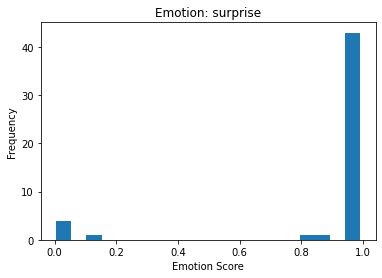

Emotion: fear
4
[0.9976968169212341, 0.9877325296401978, 0.9925300478935242, 0.9926322102546692, 0.9964796900749207, 0.996891438961029, 0.9977788329124451, 0.9978825449943542, 0.9974305033683777, 0.9803436994552612, 0.9978762865066528, 0.9966946840286255, 0.9952333569526672, 0.9977208971977234, 0.9977238774299622, 0.9970070719718933, 0.9399372339248657, 0.9976710677146912, 0.9970171451568604, 0.8195503950119019, 0.9949347376823425, 0.4342840313911438, 0.9968137145042419, 0.9967164397239685, 0.9130950570106506, 0.9976581335067749, 0.9975470900535583, 0.9959004521369934, 0.8857338428497314, 0.9977214932441711, 0.9805887341499329, 0.9968884587287903, 0.9972391128540039, 0.9908167123794556, 0.9976751208305359, 0.9974275231361389, 0.9946272969245911, 0.9819067120552063, 0.997541069984436, 0.9926591515541077, 0.9963222742080688, 0.9978117346763611, 0.9976047277450562, 0.9513221979141235, 0.9974693059921265, 0.9962239265441895, 0.8359899520874023, 0.9977489113807678, 0.9937973022460938, 0.997

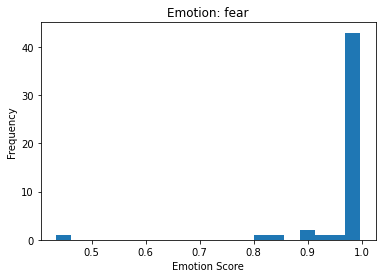

Emotion: anger
3
[0.9975094795227051, 0.9978551268577576, 0.9973717927932739, 0.9974631071090698, 0.9978394508361816, 0.9977930784225464, 0.9976638555526733, 0.9978988170623779, 0.9880901575088501, 0.9978697299957275, 0.9973450303077698, 0.9060115814208984, 0.997752845287323, 0.9967238306999207, 0.863948404788971, 0.9976171851158142, 0.9977929592132568, 0.9980413913726807, 0.9975226521492004, 0.997601330280304, 0.997974693775177, 0.9969224333763123, 0.9973974227905273, 0.9977127313613892, 0.970289945602417, 0.9978671073913574, 0.9932470321655273, 0.0005720400949940085, 0.9974960684776306, 0.9973178505897522, 0.8478907346725464, 0.18478503823280334, 0.9979661703109741, 0.9972645044326782, 0.997899055480957, 0.970289945602417, 0.9835296273231506, 0.9976826906204224, 0.997893750667572, 0.9744828939437866, 0.98723965883255, 0.9980039000511169, 0.9955443739891052, 0.997626006603241, 0.9979239702224731, 0.9979780316352844, 0.997968852519989, 0.9978220462799072, 0.9979854822158813, 0.99777966

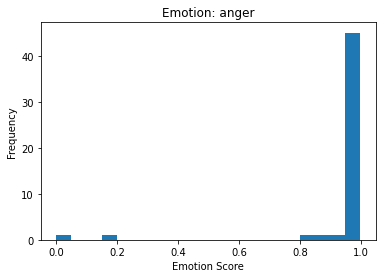

In [79]:
# For each file, generate a histogram of the emotion scores
for emotion in normalised_combined_prob:
    # Get the index of the emotion
    if emotion == 'sadness':
        index = 0
    elif emotion == 'joy':
        index = 1
    elif emotion == 'love':
        index = 2
    elif emotion == 'anger':
        index = 3
    elif emotion == 'fear':
        index = 4
    else:
        index = 5

    # Open the file
    with open(f'gen_{emotion}.txt', 'r', encoding='utf-8') as file:
        print(f'Emotion: {emotion}')
        # Initialise the emotion scores
        emotion_scores_ = []

        # Get the emotion score for the emotion of each sentence
        for line in file:
            emotion_scores_temp = emotion_scores(line)
            emotion_scores_.append(emotion_scores_temp[index]['score'])
        print(index)
        print(emotion_scores_)
        
        # Plot a line curve of the emotion scores
        plt.hist(emotion_scores_, bins=20)
        plt.xlabel('Emotion Score')
        plt.ylabel('Frequency')
        plt.title(f'Emotion: {emotion}')
        plt.show()

### Extrinsic Evaluation

In [80]:
# Training a SVC model to classify the emotions of the sentences on our corpus
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [82]:
# Training corpus from bigram_lm
corpus = bigram_lm.corpus
labels = bigram_lm.labels

# Print 5 sentences and their corresponding labels randomly
for i in range(5):
    index = np.random.randint(len(corpus))
    print(corpus[index], labels[index])

['i', 'feel', 'so', 'heartless', 'sometimes', 'because', 'i', 'do', 'not', 'have', 'the', 'ability', 'to', 'mourn', 'for', 'the', 'lost', 'of', 'someone', 'relating', 'to', 'my', 'past', 'grandparents'] anger
['i', 'feel', 'suffocated', 'yet', 'charmed', 'my', 'brain', 'pauses', 'logic'] joy
['i', 'would', 'rather', 'take', 'my', 'chances', 'on', 'keeping', 'my', 'heart', 'and', 'getting', 'it', 'broken', 'again', 'and', 'again', 'then', 'to', 'stop', 'feeling', 'to', 'stop', 'caring', 'to', 'be', 'bitter', 'cross', 'cynical'] love
['i', 'could', 'feel', 'what', 'was', 'going', 'to', 'happen', 'at', 'the', 'very', 'end', 'but', 'it', 'still', 'startled', 'me'] fear
['i', 'get', 'really', 'sweaty', 'during', 'these', 'episodes', 'and', 'my', 'stomach', 'will', 'feel', 'really', 'funny', 'like', 'i', 'm', 'free', 'falling'] surprise


In [84]:
# Apply the TfidfVectorizer to the corpus
vectorizer = TfidfVectorizer(max_features=512)
X = vectorizer.fit_transform([' '.join(sentence) for sentence in corpus])

# See the shape of the feature matrix
print(X.shape)

(2400, 512)


In [85]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

# Define the parameters for the grid search
param_grid = {'C': [0.1, 1, 10, 100], 
              'gamma': [1, 0.1, 0.01, 0.001], 
              'kernel': ['rbf', 'linear', 'poly', 'sigmoid']}

# Grid Search on the SVC model
grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=2, cv=5, n_jobs=-1)

# Fit the model
grid.fit(X_train, y_train)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Fitting 5 folds for each of 64 candidates, totalling 320 fits
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKE

GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['rbf', 'linear', 'poly', 'sigmoid']},
             verbose=2)

In [86]:
# Print the best parameters
print(grid.best_params_)
print(grid.best_estimator_)

{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
SVC(C=10, gamma=0.1)


In [87]:
# Predict the labels of the test set
y_pred = grid.predict(X_test)

# Calculate the accuracy of the model
print(accuracy_score(y_test, y_pred))

0.61875


In [88]:
# Train the model on the entire dataset
final_model = grid.best_estimator_
final_model.fit(X, labels)

# Save the model to a pickle file
with open('emotion_classifier.pkl', 'wb') as file:
    pickle.dump(final_model, file)

In [89]:
# Load the model from the pickle file
with open('emotion_classifier.pkl', 'rb') as file:
    model = pickle.load(file)

In [90]:
# Test the model on the generated sentences
X_test = []
y_test = []

# Get the generated sentences and append them to X_test and emotion labels to y_test
for emotion in normalised_combined_prob:
    with open(f'gen_{emotion}.txt', 'r', encoding='utf-8') as file:
        for line in file:
            X_test.append(line)
            y_test.append(emotion)

# Apply the TfidfVectorizer to the generated sentences
X_test = vectorizer.transform(X_test)

# Predict the labels of the generated sentences
y_pred = model.predict(X_test)

# Calculate the accuracy of the model
print(accuracy_score(y_test, y_pred))


0.7833333333333333
